<a href="https://colab.research.google.com/github/ioskn/mldl_htwg/blob/master/boosting/Least_Square_Boosting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Least Square Boosting

* We implement the least square boosting by "hand". To make the code easy, we only consider the training data. 
* Then we demonstrate that this methods is the same then the scikit-learn implementation. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
plt.style.use('default')

In [2]:
import numpy as np
import pandas as pd
from sklearn import datasets
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('default')
from sklearn import tree

In [34]:
# Import the necessary modules and libraries
import numpy as np
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt

# Create a random dataset
rng = np.random.RandomState(1)
num_data = 500
X = np.linspace(0,5,num_data).reshape(num_data,1)
y = np.sin(X).ravel() + np.random.normal(0,0.05,num_data)

def plot_current_f(X,y,ypreds, M):
    plt.scatter(X, y, s=20, edgecolor="black", c="darkorange", label="data", alpha=0.5)
    plt.plot(X, ypreds, color="cornflowerblue",label="max_depth=1", linewidth=2)
    plt.title('Number of trees : {}'.format(M))

#### M = 1 The first stump

Here we fit a simple stump (high bias) to the data. 

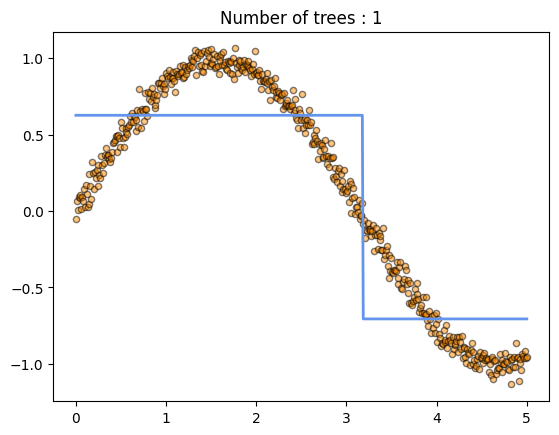

In [35]:
# Fit regression model
tree1 = DecisionTreeRegressor(max_depth=1)
tree1.fit(X, y)
ypreds = tree1.predict(X)
plot_current_f(X,y,ypreds, 1)

#### M = 1...3 The first 3 Stages

Here we fit a simple stump (high bias) to the data. Then, we fit a "delta" model to the residuals.

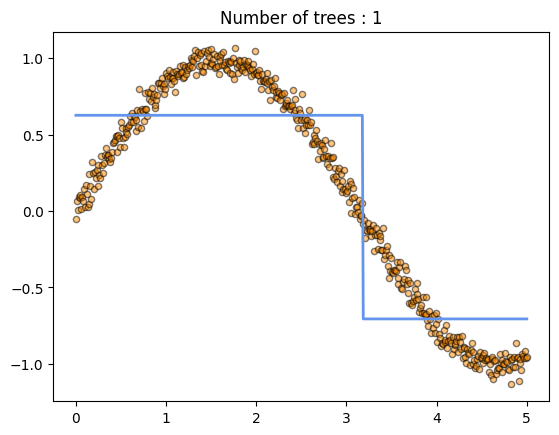

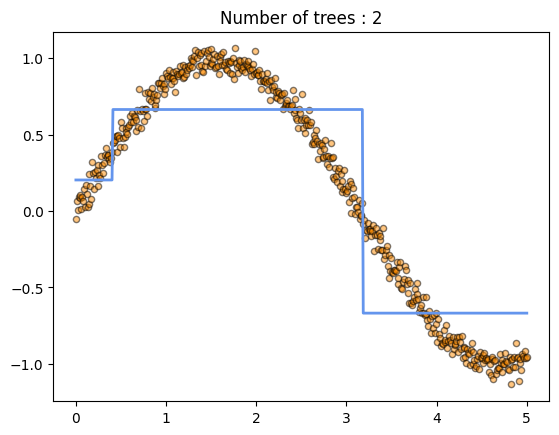

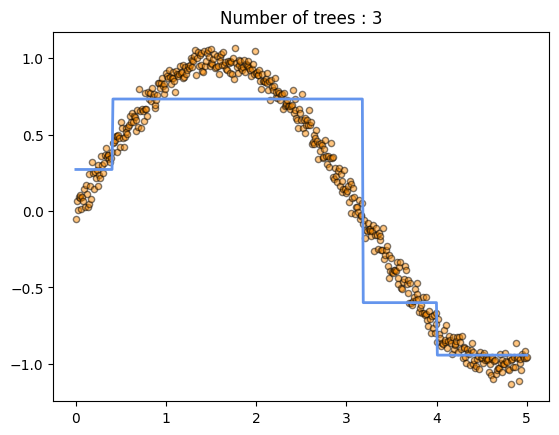

In [36]:
fx = np.zeros(num_data) #See Step 1 in Algo 10.2
for m in range(3):
    tree = DecisionTreeRegressor(max_depth=1)
    res = y - fx #Calculation of the rediduals
    tree.fit(X, res) #Fitting to the residuals (Steps 2a)
    fx = fx + tree.predict(X) #The new predictions (Step 2b)
    plot_current_f(X,y,fx,m+1)
    plt.show()

# Comparison with scikit-learn implementation

In [46]:
LR = 1 #Change to lower values (see later)
n_estimators = 20 #Number of trees

In [47]:
fx = np.zeros(num_data) #See Step 1 in Algo 10.2
for m in range(n_estimators):
    tree = DecisionTreeRegressor(max_depth=1)
    res = y - fx #Calculation of the rediduals
    tree.fit(X, res) #Fitting to the residuals (Steps 2a)
    fx = fx + LR * tree.predict(X) #The new predictions (Step 2b) with LR

Difference between our implementation an sklearn : 1.8285549263990173e-32


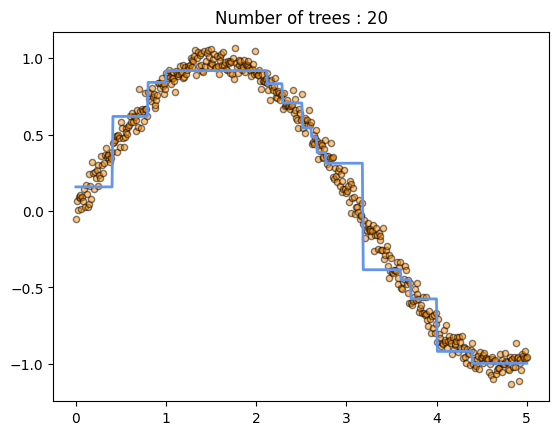

In [48]:
from sklearn.ensemble import GradientBoostingRegressor
est = GradientBoostingRegressor(n_estimators=n_estimators, learning_rate=LR,
                                max_depth=1, random_state=0, loss='ls')
est.fit(X, y)
ypred = est.predict(X) 
plot_current_f(X,y,ypred, n_estimators)
print("Difference between our implementation an sklearn :", np.mean((fx - ypred)**2))

**Play Around** Change the number of estimators to 1000 and see what happens 

# Overfitting

We now want to invesitate the issue of overfitting. For this purpose, we create a limited amount of training data. A little technicallity: We switch to the sklearn implementation, since it allows for test-data points.

In [49]:
def create_data():
    X = np.sort(5 * rng.rand(80, 1), axis=0)
    y = np.sin(X).ravel() + np.random.normal(0,0.25,80)
    return X,y

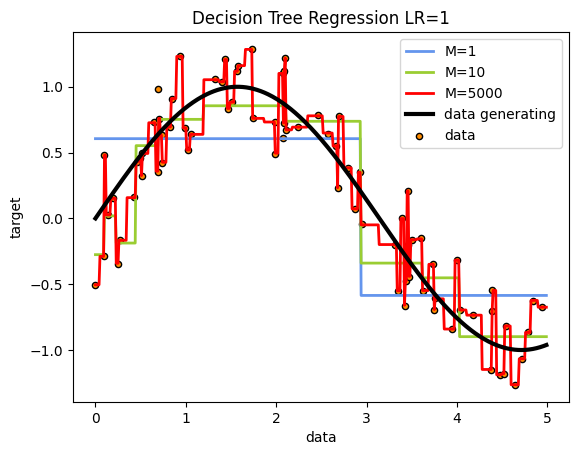

In [50]:
LR = 1
max_tree = 5000
X,y = create_data()
# Fit regression model
regr_1 = GradientBoostingRegressor(n_estimators=1, learning_rate=LR,max_depth=1, random_state=0, loss='ls')
regr_2 = GradientBoostingRegressor(n_estimators=10, learning_rate=LR,max_depth=1, random_state=0, loss='ls')
regr_3 = GradientBoostingRegressor(n_estimators=max_tree, learning_rate=LR,max_depth=1, random_state=0, loss='ls')
regr_1.fit(X, y)
regr_2.fit(X, y)
regr_3.fit(X, y)
X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]
y_1 = regr_1.predict(X_test)
y_2 = regr_2.predict(X_test)
y_3 = regr_3.predict(X_test)
plt.figure()
plt.scatter(X, y, s=20, edgecolor="black", c="darkorange", label="data")
plt.plot(X_test, y_1, color="cornflowerblue",label="M=1", linewidth=2)
plt.plot(X_test, y_2, color="yellowgreen", label="M=10", linewidth=2)
plt.plot(X_test, y_3, color="red", label="M={}".format(max_tree), linewidth=2)
plt.plot(X_test[:,0], np.sin(X_test[:,0]), linewidth=3, color='black',label="data generating")
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression LR={}".format(LR))
plt.legend()
plt.show()

For M=5000, we see a clear sign of overfitting. Let's plot the MSE to the DGP vs. M.

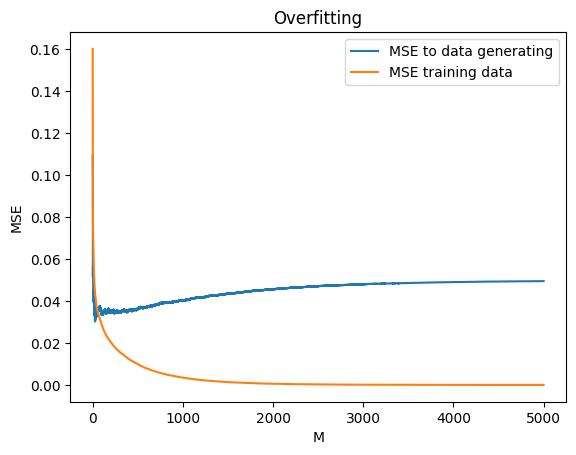

In [51]:
X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]
y_test_dg = np.sin(X_test).ravel()

reg = GradientBoostingRegressor(n_estimators=max_tree, learning_rate=LR,max_depth=1, random_state=0, loss='ls')
reg.fit(X,y)

test_score = np.zeros((max_tree), dtype=np.float64)
for m, y_pred in enumerate(reg.staged_predict(X_test)):
    test_score[m] = np.mean((y_pred - y_test_dg)**2)

train_score = np.zeros((max_tree), dtype=np.float64)
for m, y_pred in enumerate(reg.staged_predict(X)):
    train_score[m] = np.mean((y_pred - y)**2)

    
plt.plot(test_score, label='MSE to data generating')
plt.plot(train_score, label='MSE training data')
plt.title('Overfitting')
plt.xlabel('M')
plt.ylabel('MSE')
plt.legend()

## Introducation of a learning rate

In the code from above, we do not completly add the "delta" model but just a bit.
```
fx = np.zeros(num_data) #See Step 1 in Algo 10.2
for m in range(n_estimators):
    tree = DecisionTreeRegressor(max_depth=1)
    res = y - fx #Calculation of the rediduals
    tree.fit(X, res) #Fitting to the residuals (Steps 2a)
    fx = fx + LR * tree.predict(X) #<--- The new predictions (Step 2b) with LR
```

Rerun the code above and change the learning rate.

1.0
1.0 0.030227
0.5
0.5 0.01891
0.1
0.1 0.013624
0.05
0.05 0.013719
0.01
0.01 0.013743


(0.0, 0.08)

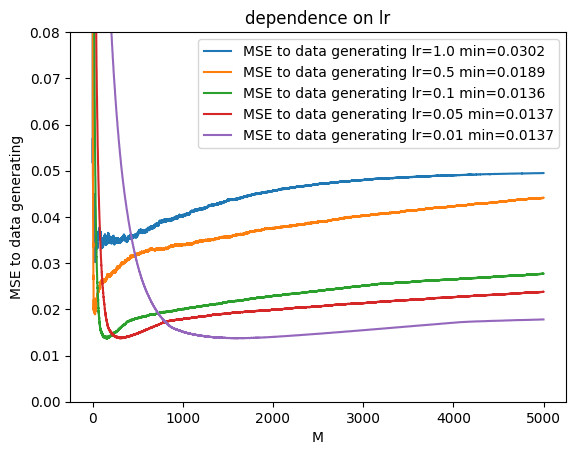

In [52]:
X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]
y_test_dg = np.sin(X_test).ravel()

lr = np.asarray([1., 0.5, 0.1, 0.05, 0.01])
lr_res = np.zeros((len(lr),max_tree))

for i,lr in enumerate(lr):
    print(lr)
    reg = GradientBoostingRegressor(n_estimators=max_tree, learning_rate=lr,max_depth=1, random_state=0, loss='ls')
    reg.fit(X,y)
    test_score = np.zeros((max_tree), dtype=np.float64)
    for m, y_pred in enumerate(reg.staged_predict(X_test)):
        test_score[m] = np.mean((y_pred - y_test_dg)**2)
    plt.plot(test_score, label='MSE to data generating lr={} min={}'.format(lr,round(np.min(test_score),4)))
    print(lr, round(np.min(test_score),6))

plt.title('dependence on lr')
plt.xlabel('M')
plt.ylabel('MSE to data generating')
plt.legend()
plt.ylim(0, 0.08)

#     for m, y_pred in enumerate(reg.staged_predict(X_test)):
#         lr_res[i,m] = np.mean((y_pred - y_test_dg)**2)

## Another view on the learning rate

**The following code is just there to produce the figure**

The learning rate resembles the stepwidth of a gradient descent. A small learning rate does only a small step towards the miminal solution. 

In [ ]:
# Import the necessary modules and libraries
import numpy as np
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt

# Create a random dataset
rng = np.random.RandomState(1)
num_data = 500
X = np.linspace(0,5,num_data).reshape(num_data,1)
y = np.sin(X).ravel() + np.random.normal(0,0.05,num_data)

def plot_step(X,y,ypreds_base,ypreds):
    plt.scatter(X, y, s=20, edgecolor="black", c="darkorange", label="data", alpha=0.05)
    plt.plot(X, ypreds_base, color="cornflowerblue",label="M-1", linewidth=2)
    for lr in [0.1,0.5,1.0]:
        if lr < 1:
            plt.plot(X, ypreds_base + lr * delta, color="green",label="M lr={}".format(lr), linewidth=1, alpha=0.6)
        else:
            plt.plot(X, ypreds_base + lr * delta, color="green",label="M lr={}".format(lr), linewidth=2, alpha=1)
    plt.title('From M to M+1')

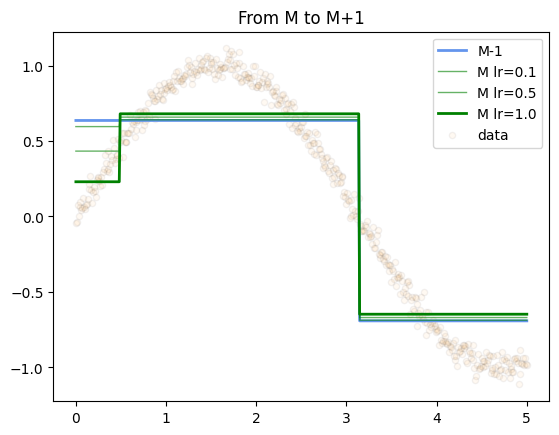

In [ ]:
# Fit regression model
fx  = delta = fx_old = np.zeros(num_data) 

for m in range(2):
    tree = DecisionTreeRegressor(max_depth=1)
    res = y - fx #Calculation of the rediduals
    tree.fit(X, res) #Fitting to the residuals (Steps 2a)
    fx_old = fx
    delta = tree.predict(X)
    fx = fx + delta #The new predictions (Step 2b) with LR
    
ypreds_base = np.zeros_like(ypreds)
plot_step(X,y,fx_old,delta)
plt.legend()